In [1]:
import time

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LinearRegression

import numpy as np
import matplotlib.pyplot as plt

import data_utils.data_analysis as data_analysis
import models.tools as models_tools
import models.rf as rf

In [2]:
#define the neural network
class perceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1=nn.Linear(3,10)
        self.act1= nn.ReLU()
        self.hidden2=nn.Linear(10,15)
        self.act2=nn.ReLU()
        self.hidden3=nn.Linear(15,25)
        self.act3=nn.ReLU()
        self.hidden4=nn.Linear(25,30)
        self.act4=nn.ReLU()
        self.hidden5=nn.Linear(30,30)
        self.act5=nn.ReLU()
        self.output=nn.Linear(30,22)

    def forward(self,x):
        x=self.act1(self.hidden1(x))
        x=self.act2(self.hidden2(x))
        x=self.act3(self.hidden3(x))
        x=self.act4(self.hidden4(x))
        x=self.act5(self.hidden5(x))
        x=self.output(x)
        return x

In [3]:
def train_fc_nn(y_train_tensor,X_train_tensor,y_test_tensor,X_test_tensor,
			device,n_epochs,batch_size,print_freq,learning_rate):
	
	startTime = time.time()
	#Create the model and define the loss and optimizer
	nn_fc_model=perceptron().to(device)
	#nn_model=cnn().to(device)
	#print(nn_fc_model)

	loss_func=nn.MSELoss() #mean squared error
	optimizer = optim.Adam(nn_fc_model.parameters(), lr=learning_rate)

	#main training loop
	train_error=[]
	test_error=[]
	epoch_list=[]
	for epoch in range(n_epochs):
    	# set the model in training mode
		nn_fc_model.train()

		train_loss=0
		for i in range(0,len(X_train_tensor),batch_size):
			X_batch=X_train_tensor[i:i+batch_size]
			y_batch=y_train_tensor[i:i+batch_size]
			X_batch, y_batch =(X_batch.to(device), y_batch.to(device))
			y_predict_nn=nn_fc_model(X_batch)
			loss=loss_func(y_predict_nn,y_batch)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			train_loss += loss

    	#get training error
		train_loss=train_loss/(len(X_train_tensor)/batch_size)
		train_error.append(train_loss.detach().cpu().numpy())
    	#evaluate test error
		with torch.no_grad():
			nn_fc_model.eval()
			(X_test_tensor, y_test_tensor) = (X_test_tensor.to(device), y_test_tensor.to(device))
			y_predict_test=nn_fc_model(X_test_tensor)
			test_loss=loss_func(y_predict_test,y_test_tensor)
			test_error.append(test_loss.detach().cpu().numpy())

		epoch_list.append(epoch+1)
    
		if(epoch%print_freq==0 or epoch+1==n_epochs):
			print(f'Finished epoch {epoch},latest loss {train_loss}')
	#print(train_error)
	#print(test_error)
	endTime = time.time()
	print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))
	
	return nn_fc_model,train_error,test_error

In [4]:
def norm_data(X_data,X_norm):
	#X_data is the array we want to normalize
	#X_norm is what we are using to normalize
	X_norm_out=X_data.copy()
	
	X_norm_out['order2']= (X_norm_out['order2']-X_norm['order2'].mean())/X_norm['order2'].std()
	
	X_norm_out['order3']= (X_norm_out['order3']-X_norm['order3'].mean())/X_norm['order3'].std()
	

	X_norm_out['order4']= (X_norm_out['order4']-X_norm['order4'].mean())/X_norm['order4'].std()
	
	
	#print(X_norm_out['order4'])
	
	return X_norm_out

In [5]:
def make_fc_nn_prediction(nn_fc_model,X_test,y_train,device):
    #Use NORMALIZED tensors as input in the forward model
    
	#convert input to tensor
	#y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)
	X_test_tensor=torch.tensor(X_test.to_numpy(),dtype=torch.float32)
	X_test_tensor=X_test_tensor.to(device)
	
	#make prediction
	y_predict_fc_nn_tensor=nn_fc_model(X_test_tensor)
	y_predict_fc_nn=y_predict_fc_nn_tensor.detach().cpu().numpy()
	
	#renormalize (using the SAME, as before, X_train)
    #NO NEED IN THE FORWARD
	#X_predict_fc_nn_renorm=renorm_data(X_predict_fc_nn,X_train)
	
	return y_predict_fc_nn

In [6]:
filename='datasets/galadriel_dataset_24_06_28.h5'
df_input,df_time_val,df_time,df_freq_val,df_freq_int = data_analysis.read_dataset(filename)

Input DF
       shot number  order2  order3     order4
0           136497   34900  -17000 -4600000.0
1           136498   34900  -17000 -4600000.0
2           136499   34900  -17000 -4600000.0
3           136500   34900  -17000 -4500000.0
4           136501   34900  -17000 -4500000.0
...            ...     ...     ...        ...
15503       152002   35400   29000 -3800000.0
15504       152003   35400   29000 -3800000.0
15505       152004   35400   29000 -3700000.0
15506       152005   35400   29000 -3700000.0
15507       152006   35400   29000 -3700000.0

[15508 rows x 4 columns]
----
Time values
0    -115.458450
1    -104.962227
2     -94.466005
3     -83.969782
4     -73.473559
5     -62.977336
6     -52.481114
7     -41.984891
8     -31.488668
9     -20.992445
10    -10.496223
11      0.000000
12     10.496223
13     20.992445
14     31.488668
15     41.984891
16     52.481114
17     62.977336
18     73.473559
19     83.969782
20     94.466005
21    104.962227
Name: 0, dtype: float6

In [7]:
#split the dataset (X:dazzler param, Y:wizzler)
X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
#Reset the index on y_test to have the same indexes as y_predict
y_test_reset=y_test.reset_index(drop=True)

In [8]:
#normalize target
X_train_norm=norm_data(X_train,X_train)
X_test_norm=norm_data(X_test,X_train) #normalized by the SAME values
	
#convert data to tensors (use normalized values)
X_train_tensor=torch.tensor(X_train_norm.values,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train.values,dtype=torch.float32)

X_test_tensor=torch.tensor(X_test_norm.values,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)
	
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device="cpu"
print("We are using:",device)

We are using: cpu


In [9]:
#train the model

#hyperparameters
n_epochs=100
batch_size=40
print_freq=10
learning_rate=0.002

nn_fc_model,train_error,test_error=train_fc_nn(y_train_tensor,X_train_tensor,y_test_tensor,X_test_tensor,
                        device,n_epochs=n_epochs,batch_size=batch_size,print_freq=print_freq,learning_rate=learning_rate)

Finished epoch 0,latest loss 0.01671265810728073
Finished epoch 10,latest loss 0.005813928321003914
Finished epoch 20,latest loss 0.005333260633051395
Finished epoch 30,latest loss 0.005129440221935511
Finished epoch 40,latest loss 0.00503103993833065
Finished epoch 50,latest loss 0.004954101983457804
Finished epoch 60,latest loss 0.004877198487520218
Finished epoch 70,latest loss 0.004796155728399754
Finished epoch 80,latest loss 0.004735170863568783
Finished epoch 90,latest loss 0.004681270103901625
Finished epoch 99,latest loss 0.004660998471081257
Total time taken to train the model: 18.48s


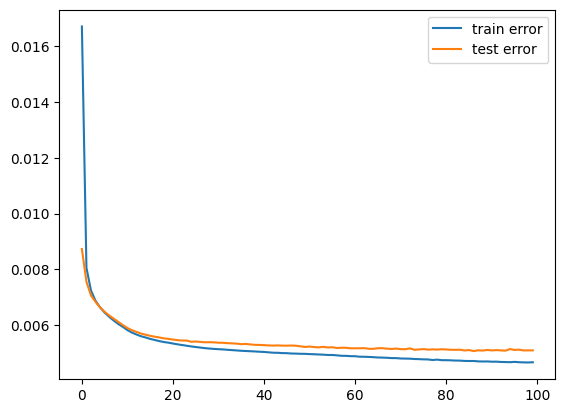

In [10]:
plt.plot(train_error,label='train error')
plt.plot(test_error,label='test error')
plt.legend()
#plt.yscale('log')

In [11]:
#predictions
y_predict_fc_nn=make_fc_nn_prediction(nn_fc_model,X_test_norm,y_train,device)

#study the erro distribution
df_error_forward_nn=abs(y_test_reset-y_predict_fc_nn)
df_error_forward_nn=df_error_forward_nn.sum(axis=1)/y_test.shape[1] #sum error / num columns

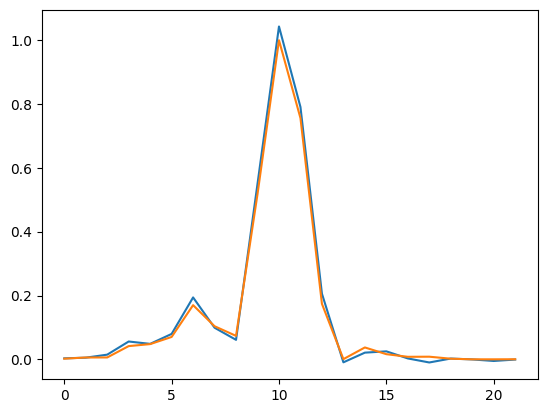

In [12]:
plt.plot(y_predict_fc_nn[200])
plt.plot(y_test_reset.loc[200])

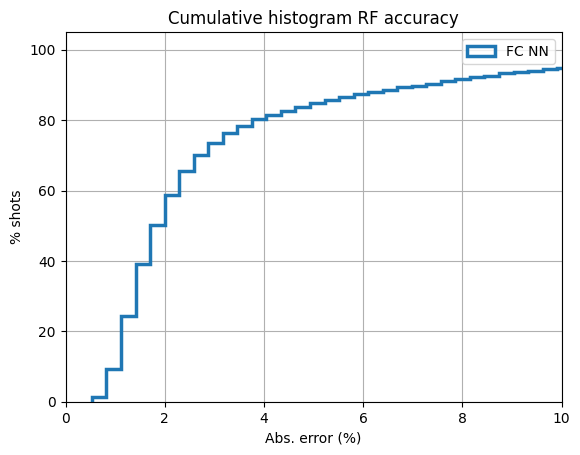

In [13]:
weights_forward_nn = 100*np.ones_like(df_error_forward_nn) / len(df_error_forward_nn)
(100*df_error_forward_nn).hist(bins=100,weights=weights_forward_nn,cumulative=True,histtype="step",linewidth=2.5,label='FC NN')

plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram RF accuracy')
plt.xlim(0,10)
plt.legend()
plt.show()

### Comprare the mode with Random Forest

In [14]:
def train_forward_rf(df_input,df_time):
    #split the dataset (X:dazzler param, Y:wizzler)
    X_train, X_test, y_train, y_test=models_tools.split_dataset_roundtrip(df_input,df_time,rand_split=False)
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    n_estimators = 300
    max_features = 'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf,df_error_forward_rf

**Linear model**

In [15]:
#train the forward linear model
forward_model_lin=LinearRegression().fit(X_train,y_train)
y_predict_lin=forward_model_lin.predict(X_test)

df_error_forward_lin=abs(y_test_reset-y_predict_lin)
df_error_forward_lin=df_error_forward_lin.sum(axis=1)/y_test.shape[1] #sum error / num columns

In [16]:
forward_model_rf,df_error_forward_rf=train_forward_rf(df_input,df_time)

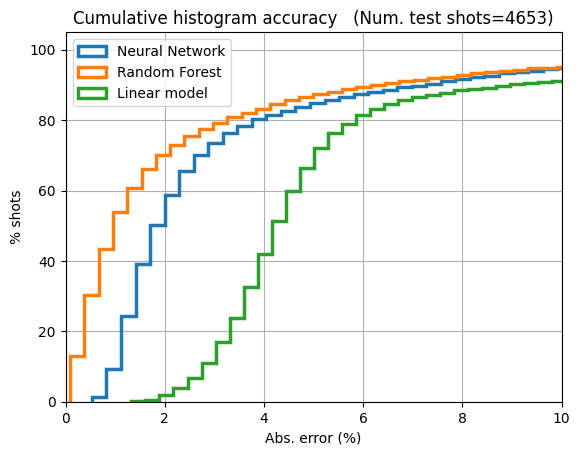

In [22]:
weights_forward_nn = 100*np.ones_like(df_error_forward_nn) / len(df_error_forward_nn)
weights_forward_rf = 100*np.ones_like(df_error_forward_rf) / len(df_error_forward_rf)
weights_forward_lin = 100*np.ones_like(df_error_forward_lin) / len(df_error_forward_lin)
(100*df_error_forward_nn).hist(bins=100,weights=weights_forward_nn,cumulative=True,histtype="step",linewidth=2.5,label='Neural Network')
(100*df_error_forward_rf).hist(bins=100,weights=weights_forward_rf,cumulative=True,histtype="step",linewidth=2.5,label='Random Forest')
(100*df_error_forward_lin).hist(bins=100,weights=weights_forward_lin,cumulative=True,histtype="step",linewidth=2.5,label='Linear model')


plt.ylabel('% shots')
plt.xlabel('Abs. error (%)')
plt.title('Cumulative histogram accuracy   (Num. test shots='+str(len(df_error_forward_nn))+')')
plt.xlim(0,10)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Model accuracy')

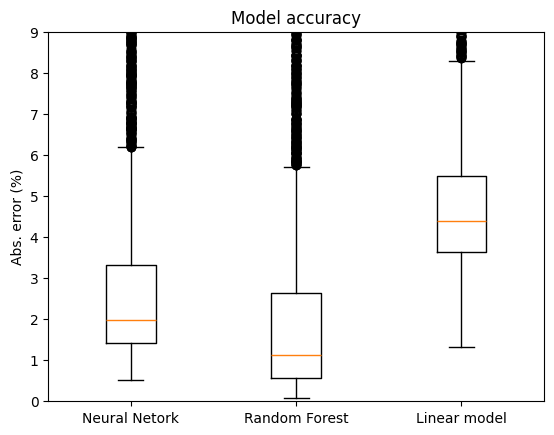

In [26]:
error_dist=[100*df_error_forward_nn,
            100*df_error_forward_rf,
            100*df_error_forward_lin]
labels=['Neural Netork','Random Forest','Linear model']
plt.boxplot(error_dist,labels=labels)
#plt.boxplot(df_error_forward_7k_whole)
#plt.boxplot(df_error_forward_4k_whole)
plt.ylim(0,9)
plt.ylabel('Abs. error (%)')
plt.title('Model accuracy')